The objective of this project is to use physics-informed neural networks (PINNs) (**Method 1**) and physics-informed regression using linear basis functions (**Method 2**) to solve a forward and inverse heat transfer via conduction in a plate.  The problem is assumed to be non-dimensionalized and therefore, no unit is used.  The plate geometry is a square with length $L=1$. The plate is heated with a heat source $q(x_1,x_2)$ centered at $(x_1^{(0)},x_2^{(0)})$. The heat source distribution is approximated by:
\begin{equation*}
q(x_1,x_2) = a \exp(-b (x_1-x_1^{(0)})^2-b (x_2-x_2^{(0)})^2), \qquad \text{(1)}
\end{equation*}
where $a$ and $b$ are constants. The plate boundaries are kept at a constant temperature of $T=T_b$.

The steady-state distribution of temperature is governed by
\begin{equation*}
    k(\frac{\partial^2{T}}{\partial x_1^2}+\frac{\partial^2{T}}{\partial x_2^2})+q(x_1,x_2)=0, \qquad \text{(2)}
\end{equation*}
where $T=T(x_1,x_2)$ is the temperature and $k$ is the plate conductivity. Let us assume we have some noisy temperature measurements at the boundary and at random interior points. Let us also assume that $a=250$, $b=20$, $x_1^{(0)}=\frac{1}{6}$, $x_2^{(0)}=\frac{1}{2}$, $T_b=0$ and $k=0.1$. In the following we adopt the generic notation of $y \leftarrow T$ and $x \leftarrow (x_1,x_2)$.  In this project you will build two kinds of regression models: (i) data-driven regression model; (ii) physics-informed regression model.

**Method 1** (60 points)

Below is code for a feed-forward neural network with one layer and $m$ hidden units where $y(x; \mathbf{w}) = W^{(2)} h (W^{(1)} x + b^{(1)}) + b^{(2)}$ and **params** denotes all the weights and biases. In all parts of this project use *N_test=75, sigma=2* and the number of hidden units is *m=40*.

The regression model is run in the data-driven mode with **X_train** and **Y_train**. Out of the 225 training data points, 215 measurements are  taken at the boundaries and only 10 measurements are taken at the interior points.  The contour lines of the temperature obtained from the regressed model are plotted and compared against truth (*T* from *data.npz*).  

The **Loss** function is modified by adding the physics-informed portion of the loss function to the loss. The **d2y_dx1** and **d2y_dx2** functions compute the laplacian of the **Forward** function with respect to the second ($x_1$) and third ($x_2$) inputs, which are equal to $\frac{\partial^2{T}}{\partial x_1^2}$ and $\frac{\partial^2{T}}{\partial x_2^2}$ terms in Equation (2).


We use physics-informed regression (data+physics mode) to solve Equation (2) using noisy boundary/interior data.  We use the same setup as before for data portion and network architecture and use *N_Model = 100* randomly distributed points to enforce the model. The contour lines of the temperature are plotted using the regressed model and we compare results against the truth (*T* from *data.npz*).

We compute the generalization error for the PINN that was built above. To this end, we use **X_test** and **Y_test**. The number of test points should be equal to *N_test = 75*.  We plot the history of the generalization error as well as the training error versus iteration in one figure.

One of the favorable features of PINNs is their efficiency in solving *inverse* problems/parameter estimation. Assume that we did not know the conductivity of the plate, i.e., $k$ and use PINN to find $k$. We perform the following steps: (i) Add $k$  to the weight vector. You need to change **Init** function. (ii) Modify the **Loss** function to ensure that $k$ is updated in each iteration. (iii) Run the program to estimate temperature and conductivity. Finally, we plot the history of $k$ versus optimization iterations by modifying the plot section of the loss function and report the final value of $k$.

In [1]:
! pip install optax

import jax
import optax
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, grad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%env JAX_PLATFORM_NAME=gpu

key = jax.random.PRNGKey(2)

env: JAX_PLATFORM_NAME=gpu


<ipython-input-4-f663109468b5>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scat = ax.scatter3D(X_train[:,0],X_train[:,1],Y_train, cmap = 'jet')


Text(0.5, 1.0, 'Truth Contour Plot')

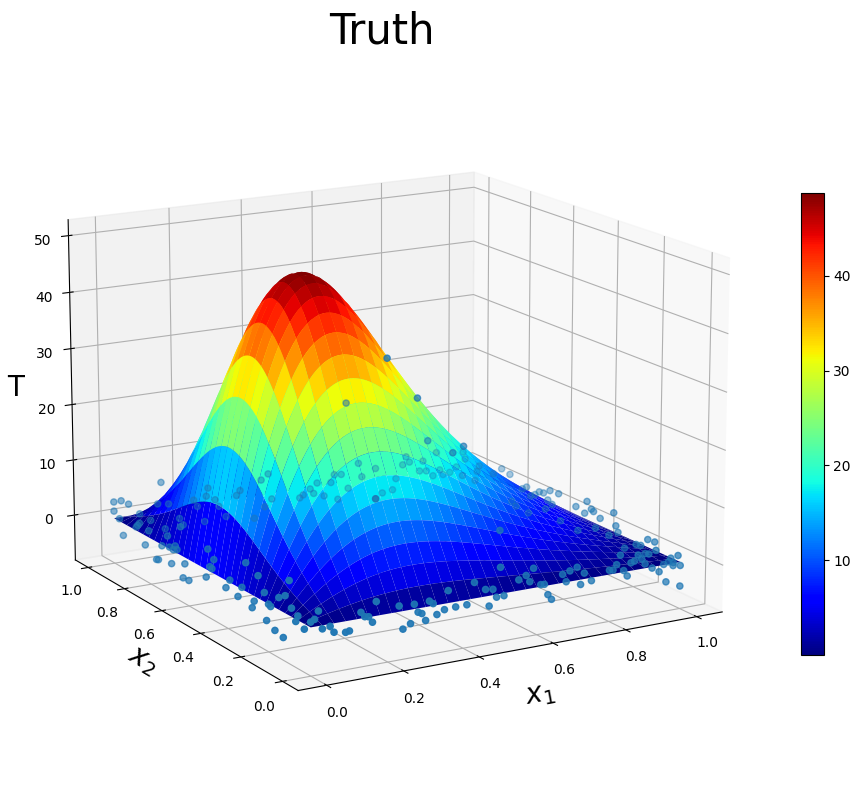

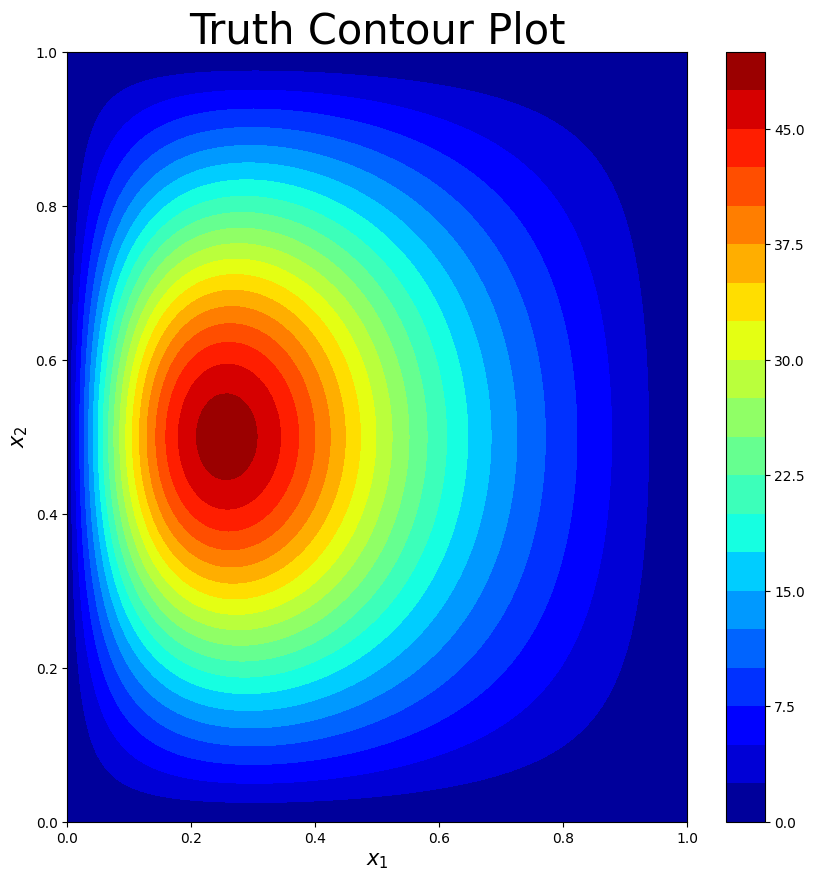

In [4]:
data = jnp.load('data.npz')
X1, X2, T, I = data['X1'], data['X2'], data['T'], data['I']

L = 1
k = 0.1
N_test  = 75
N_Model = 100
sigma = 2

I_train, I_test = I[N_test:], I[:N_test]

X_train = jnp.hstack((X1.reshape(-1,1)[I_train], X2.reshape(-1,1)[I_train]))
Y_train = T.ravel()[I_train] + sigma*jax.random.normal(key, shape=(len(I_train),))

X_test = jnp.hstack((X1.reshape(-1,1)[I_test], X2.reshape(-1,1)[I_test]))
Y_test = T.ravel()[I_test]

X_model = L*jax.random.uniform(key, shape=(N_Model,2))

q = lambda X: -250*jnp.exp(-20*(X[:,0]-L/6)**2-20*(X[:,1]-L/2)**2)


SX1, SX2 = np.meshgrid(X1[0,:],X2[:,0])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
scat = ax.scatter3D(X_train[:,0],X_train[:,1],Y_train, cmap = 'jet')
surf = ax.plot_surface(SX1, SX2, T, cmap='jet',label = 'Truth')
ax.set_xlabel(r'$x_{1}$',fontsize = 20)
ax.set_ylabel(r'$x_{2}$',fontsize = 20)
ax.set_zlabel('T',fontsize = 20)
ax.view_init(elev=15, azim=-120)
ax.set_title(r'Truth',fontsize=30)
fig.colorbar(surf, shrink = 0.5)

fig = plt.figure(figsize=(10,10))
plt.contourf(SX1,SX2,T,cmap='jet',levels=20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Truth Contour Plot',fontsize=30)

## Method 1, Part 1: Modify Forward Function

In [5]:
def Init(units, key):
    params = []
    keys = jax.random.split(key, num=4)

    w1 = jax.random.uniform(keys[0], (2, units[0]), minval=-1.0, maxval=1.0)
    b1 = jax.random.uniform(keys[1], (units[0],),   minval=-1.0, maxval=1.0)
    params.append([w1,b1])

    w2 = jax.random.uniform(keys[2], (units[0], units[1]), minval=-1.0, maxval=1.0)
    b2 = jax.random.uniform(keys[3], (units[1],), minval=-1.0, maxval=1.0)
    params.append([w2,b2])
    return params

def Forward(params, x1, x2):
    # Complete these lines
    X = jnp.hstack((x1.reshape(-1,1), x2.reshape(-1,1)))
    l1 = jnp.tanh(X @ params[0][0]  + params[0][1])
    l2 = l1 @ params[1][0] + params[1][1]
    return l2.squeeze()

units, learning_rate, epochs = [40,1], 1e-4, 100000

## Method 1, Part 2: Modify Loss Function

In [6]:
d2y_dx1 = jit(vmap(grad(grad(Forward, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward, 2), 2), in_axes=(None, 0, 0)))

@jit
def Loss(params, X_data, Y_data, X_model):
    # Complete these lines
    prediction = Forward(params,X_data[:,0],X_data[:,1])
    loss = jnp.mean((Y_data - prediction)**2)
    return loss

Gradients = grad(Loss)
params = Init(units, key)

In [7]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

## Method 1, Part 3: Run Regression, Plot, and Compare to Truth

In [8]:
for i in range(epochs):
    params, opt_state = step(params, opt_state)

Text(0.5, 1.0, 'Data Only Regression Contour Plot')

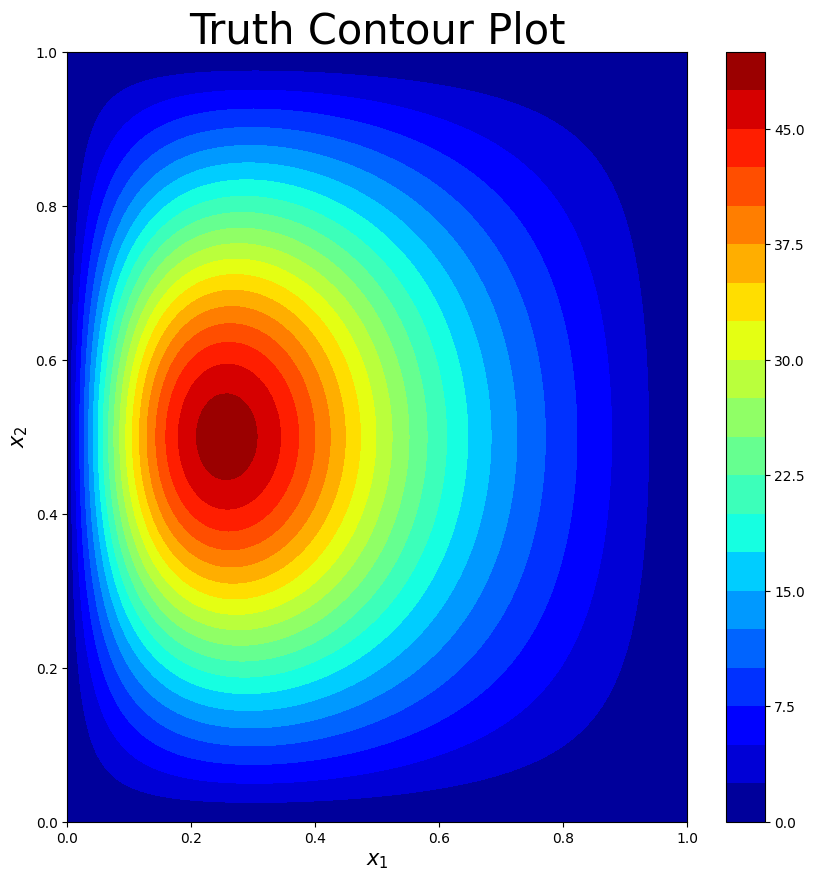

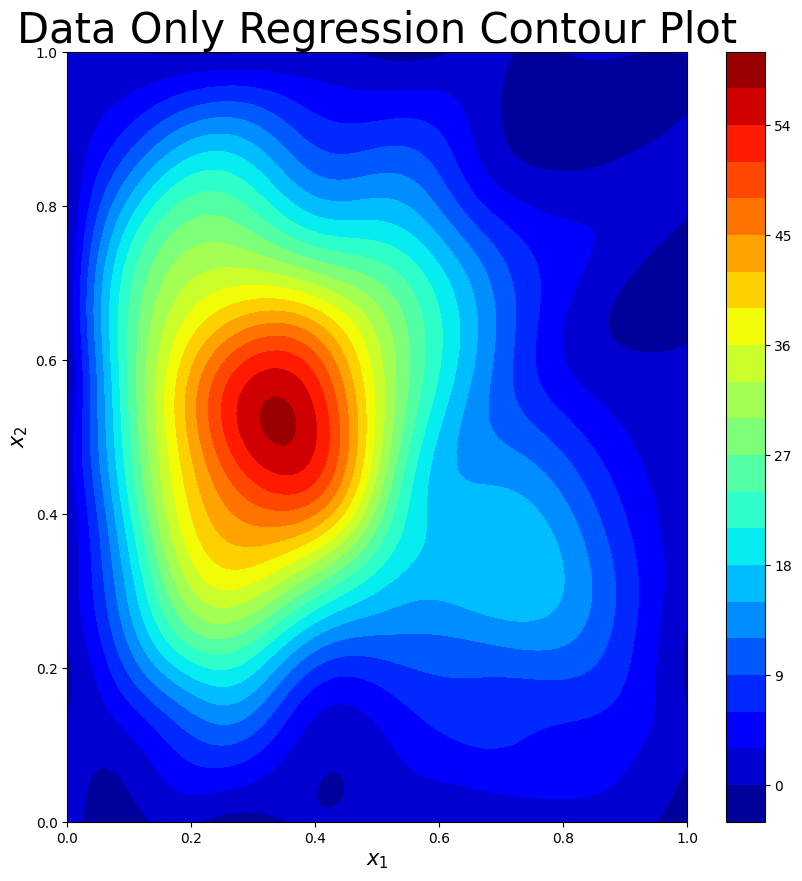

In [9]:
fig = plt.figure(figsize=(10,10))
plt.contourf(SX1,SX2,T,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Truth Contour Plot',fontsize=30)

testx = Forward(params,X1,X2)
plotx = testx.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1[0,:],X2[:,0],plotx,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Data Only Regression Contour Plot',fontsize=30)

### Comparing Truth vs Data Only Regression Model
When observing the truth contour plot, there is an obvious heat source located in the upper-left portion of the plate. The heat surrounding the source has smooth contour lines towards the boundary edges.  

When comparing the data only regression model, there is an approximate location of the source and the surrounding contour lines aren't visually equal to those observed in truth.  The regression model appears to be 'warmer' in the bottom-right when compared to truth, which will lead to errors in that region.

## Method 1, Part 4: Modify Loss Function with Physics-Informed Portion

In [10]:
@jit
def Loss(params, X_data, Y_data, X_model):
    # Complete these lines
    prediction_data = Forward(params,X_data[:,0],X_data[:,1])
    loss_data = jnp.mean((Y_data - prediction_data)**2)
    loss_model = jnp.mean((0.1*(d2y_dx1(params,X_model[:,0],X_model[:,1]) + d2y_dx2(params,X_model[:,0],X_model[:,1])) - q(X_model))**2)
    loss = loss_data + loss_model
    return loss

Gradients = grad(Loss)
params = Init(units, key)

In [11]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

## Method 1, Part 5: Physics-Informed Neural Network

In [12]:
for i in range(epochs):
    params, opt_state = step(params, opt_state)

Text(0.5, 1.0, 'Method 1 - PINN Regression Contour Plot')

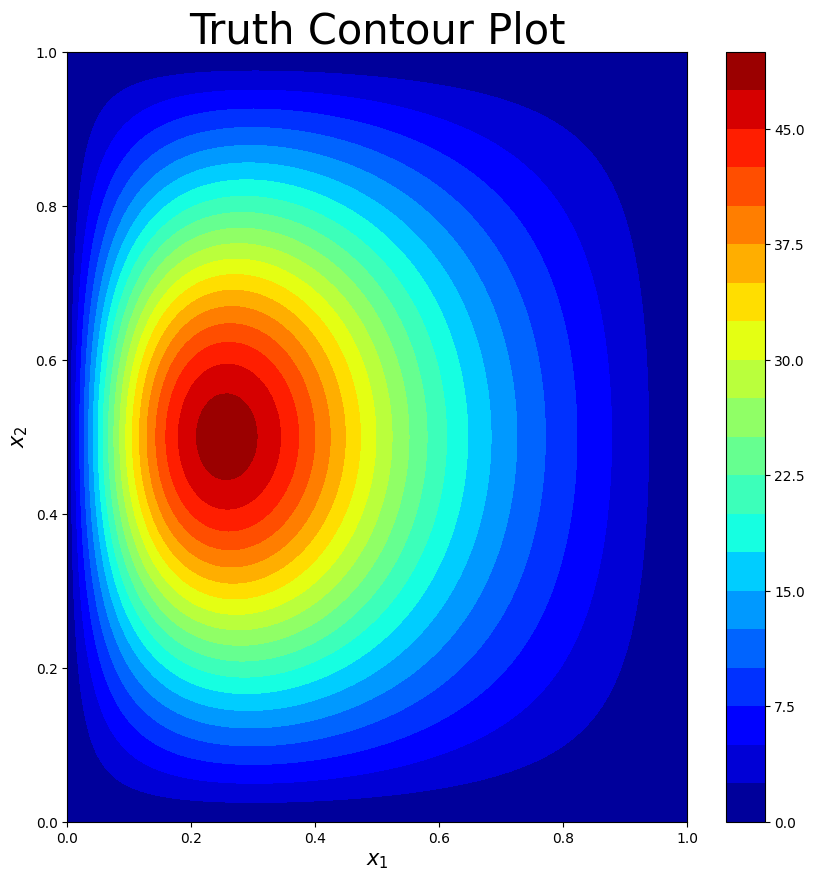

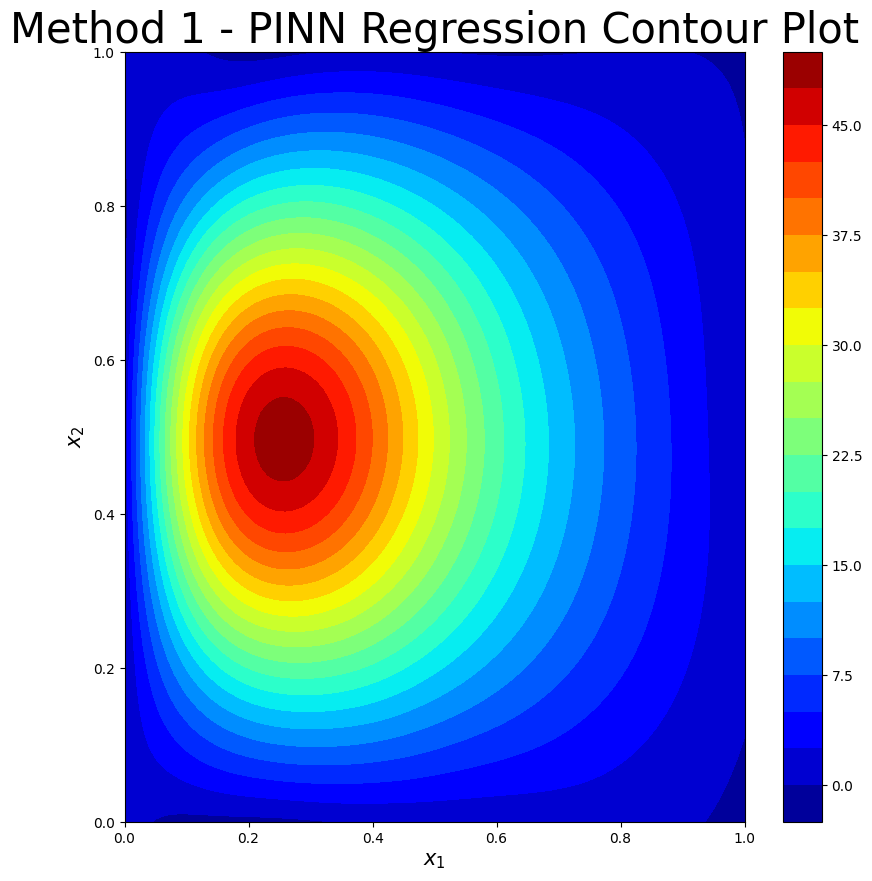

In [13]:
fig = plt.figure(figsize=(10,10))
plt.contourf(SX1,SX2,T,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Truth Contour Plot',fontsize=30)

y_PINN = Forward(params,X1,X2)
plotPINN = y_PINN.reshape(101,101)
fig = plt.figure(figsize=(10,10))
plt.contourf(X1[0,:],X2[:,0],plotPINN,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Method 1 - PINN Regression Contour Plot',fontsize=30)

### Comparing Physics-Informed Approach to Data Only Model
Immeditately we can determined visually that the physics-informed approach is superior to the data-only model.  The PINN has smoother contour lines, where the error in the bottom right of the data only model has now been corrected.  The PINN mirrors truth indicating that the error between the PINN and truth will be less than that of the data only model.

## Method 1, Part 6: Generalization Error for PINN from Part 5

In [14]:
@jit
def Loss(params, X_data, Y_data, X_model):
    # Complete these lines
    prediction_data = Forward(params,X_data[:,0],X_data[:,1])
    loss_data = jnp.mean((Y_data - prediction_data)**2)
    loss_model = jnp.mean((0.1*(d2y_dx1(params,X_model[:,0],X_model[:,1]) + d2y_dx2(params,X_model[:,0],X_model[:,1])) - q(X_model))**2)
    loss = loss_data + loss_model
    return loss

Gradients = grad(Loss)
params = Init(units, key)

In [15]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [16]:
y_tr = []
y_te = []

for i in range(epochs):
    y_tr1 = Loss(params, X_train, Y_train, X_model)
    y_te1 = Loss(params, X_test, Y_test, X_model)
    params, opt_state = step(params, opt_state)
    y_tr.append(y_tr1)
    y_te.append(y_te1)

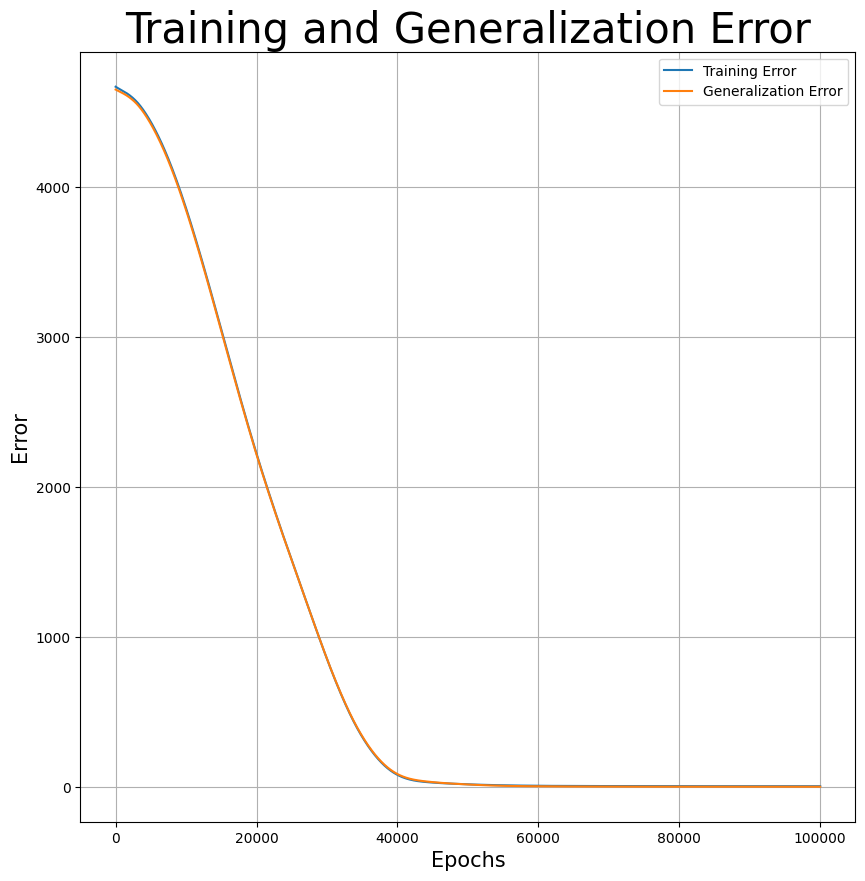

In [17]:
it_plot = jnp.linspace(1,epochs,epochs)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(it_plot, y_tr, label = 'Training Error')
ax.plot(it_plot, y_te, label = 'Generalization Error')
ax.set_xlabel('Epochs', fontsize = 15)
ax.set_ylabel('Error', fontsize = 15)
ax.grid('major')
plt.title('Training and Generalization Error', fontsize = 30)
plt.legend()

## Method 1, Part 7 (i): Inverse Problem - Adding $k$ to $\bf{Init()}$

In [18]:
def Init(units, key):
    params = []
    keys = jax.random.split(key, num=5)

    w1 = jax.random.uniform(keys[0], (2, units[0]), minval=-1.0, maxval=1.0)
    b1 = jax.random.uniform(keys[1], (units[0],),   minval=-1.0, maxval=1.0)
    params.append([w1,b1])

    w2 = jax.random.uniform(keys[2], (units[0], units[1]), minval=-1.0, maxval=1.0)
    b2 = jax.random.uniform(keys[3], (units[1],), minval=-1.0, maxval=1.0)

    k0 = k = jax.random.uniform(keys[4],(1,),minval=0.5,maxval=0.5)

    params.append([w2,b2,k0])

    #k0 = jax.random.uniform(keys[4], (units[1],), minval=-1.0, maxval=1.0)
    #params.append(k0)
    return params

units, learning_rate, epochs = [40,1], 1e-4, 100000

## Method 1, Part 7 (ii): Modify Loss Function to Ensure $k$ Update

In [19]:
@jit
def Loss(params, X_data, Y_data, X_model):
    # Complete these lines
    prediction_data = Forward(params,X_data[:,0],X_data[:,1])
    loss_data = jnp.mean((Y_data - prediction_data)**2)
    loss_model = jnp.mean(((params[1][2])*(d2y_dx1(params,X_model[:,0],X_model[:,1]) + d2y_dx2(params,X_model[:,0],X_model[:,1])) - q(X_model))**2)
    loss = loss_data + loss_model
    return loss

Gradients = grad(Loss)
params = Init(units, key)

## Method 1, Part 7 (iii): Estimating Temperature and Conductivity

In [20]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [21]:
k_it = []

for i in range(epochs):
    params, opt_state = step(params, opt_state)
    k_it.append(params[1][2])

Text(0.5, 1.0, 'Final $k$ = [0.09973104]')

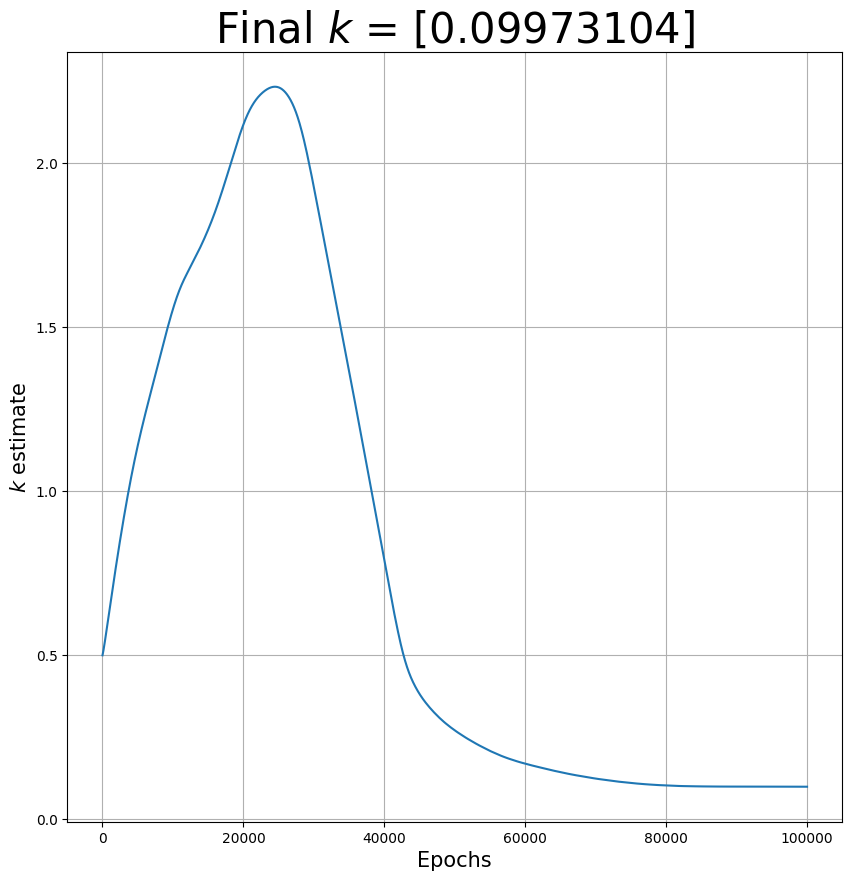

In [22]:
it_plot = jnp.linspace(1,epochs,epochs)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(it_plot, k_it)
ax.set_xlabel('Epochs', fontsize = 15)
ax.set_ylabel(r'$k$ estimate', fontsize = 15)
ax.grid('major')
plt.title(f'Final $k$ = {k_it[-1]}', fontsize = 30)

**Method 2** (40 points)
1. In this part, we build a regression model based on fixed basis functions to solve the forward problem as follows:
$$T(x_1,x_2) = f(x_1,x_2;\theta) + \eta.$$
 To this end, consider Gaussian radial basis functions in the form of:
$$ f(x_1,x_2;\theta) = \sum_{i=1}^M \sum_{j=1}^M \theta_{ij} \phi_{ij}(x_1,x_2), $$
where $M$ is the number of basis functions is each direction and the basis functions are given by
$$ \phi_{ij}(x_1,x_2) = \exp{(-(x_1-\mu_i)^2/s^2)} \exp{(-(x_2-\mu_j)^2/s^2)}, \quad i,j=1, \dots, M,$$
where $\boldsymbol{\mu}=\{(\mu_i,\mu_j)\}_{i,j=1}^M$ respresents the coordiantes of where $\phi_{ij}$ bcomes maximum. Take $M=25$. This means that you have $K=M^2$ basis functions. The vector $\boldsymbol{\mu}$  is generated randomly as shown in the cell below and $s=0.25$.  We know that finding  $\theta$ requires solving a linear system of equations. In practice, linear regression problems with very large number of paramteres (large $K$) are solved iteratively, because the cost of inverting the $\Phi^T \Phi$ matrix scales with $O(K^3)$ and for large $K$, the inverse of this matrix could be cost prohibitive.   In this problem $K$ is not really that big (because of limited computational resources avialable), but you are asked to solve this probelm using an iterative approach – an approach identical to the one you used in **Method 1**, where no matrix inversion is required. To this end, we repeat Parts 1-6 of **Method 1** and take *N_Model = 500*.

## Method 2, Part 1, 2, & 3: Regression Model on Fixed Basis with Data Only

In [23]:
K  = 25*25
s  = 0.25**2
mu = jax.random.uniform(key, shape=(2, K))


def Init(K, key):
    return [jax.random.uniform(key, (K,1), minval=-1.0, maxval=1.0)]

def Forward(params, x1, x2):

    phi = jnp.exp(-(((x1.reshape(-1,1)-mu[0].reshape(1,K))**2)/s))*jnp.exp(-(((x2.reshape(-1,1)-mu[1].reshape(1,K))**2)/s))

    f_hat = phi @ params[0]
    return f_hat.squeeze()

learning_rate, epochs = 1e-1, 100000
params = Init(K, key)

In [24]:
data = jnp.load('data.npz')
X1, X2, T, I = data['X1'], data['X2'], data['T'], data['I']

L = 1
k = 0.1
N_test  = 75
N_Model = 500
sigma = 2

I_train, I_test = I[N_test:], I[:N_test]

X_train = jnp.hstack((X1.reshape(-1,1)[I_train], X2.reshape(-1,1)[I_train]))
Y_train = T.ravel()[I_train] + sigma*jax.random.normal(key, shape=(len(I_train),))

X_test = jnp.hstack((X1.reshape(-1,1)[I_test], X2.reshape(-1,1)[I_test]))
Y_test = T.ravel()[I_test]

X_model = L*jax.random.uniform(key, shape=(N_Model,2))

q = lambda X: -250*jnp.exp(-20*(X[:,0]-L/6)**2-20*(X[:,1]-L/2)**2)

In [25]:
d2y_dx1 = jit(vmap(grad(grad(Forward, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward, 2), 2), in_axes=(None, 0, 0)))

@jit
def Loss(params, X_data, Y_data, X_model):
    y_hat = Forward(params,X_data[:,0],X_data[:,1])
    loss = jnp.mean((Y_data - y_hat)**2)
    return loss

Gradients = grad(Loss)

In [26]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [27]:
for i in range(epochs):
    params, opt_state = step(params, opt_state)

Text(0.5, 1.0, 'Method 2 - Data Only Contour Plot')

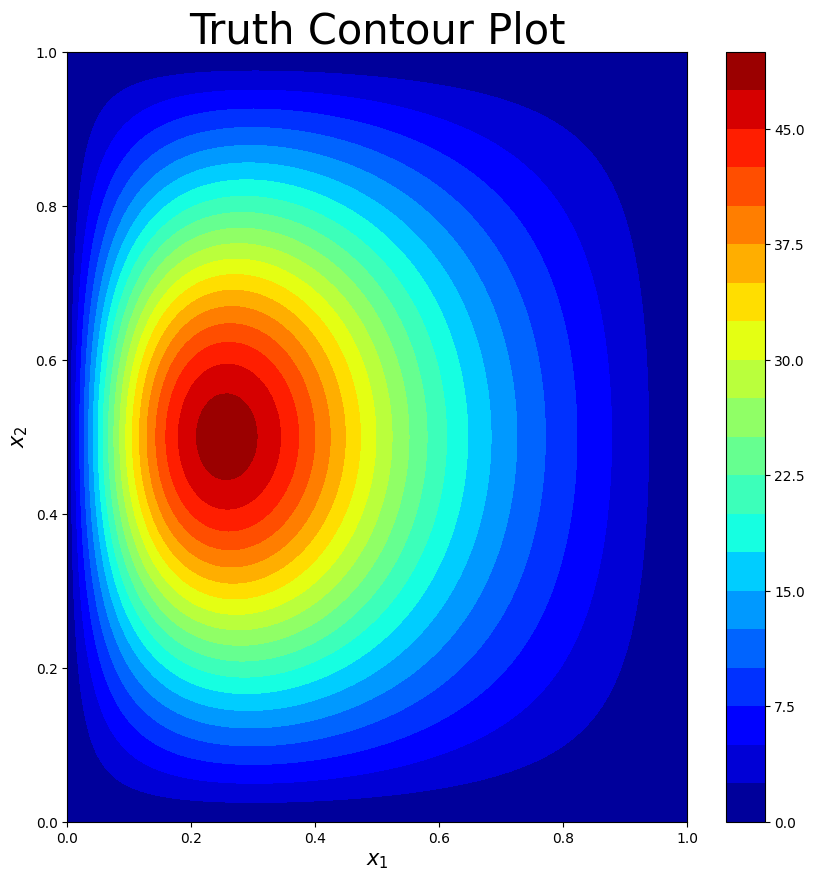

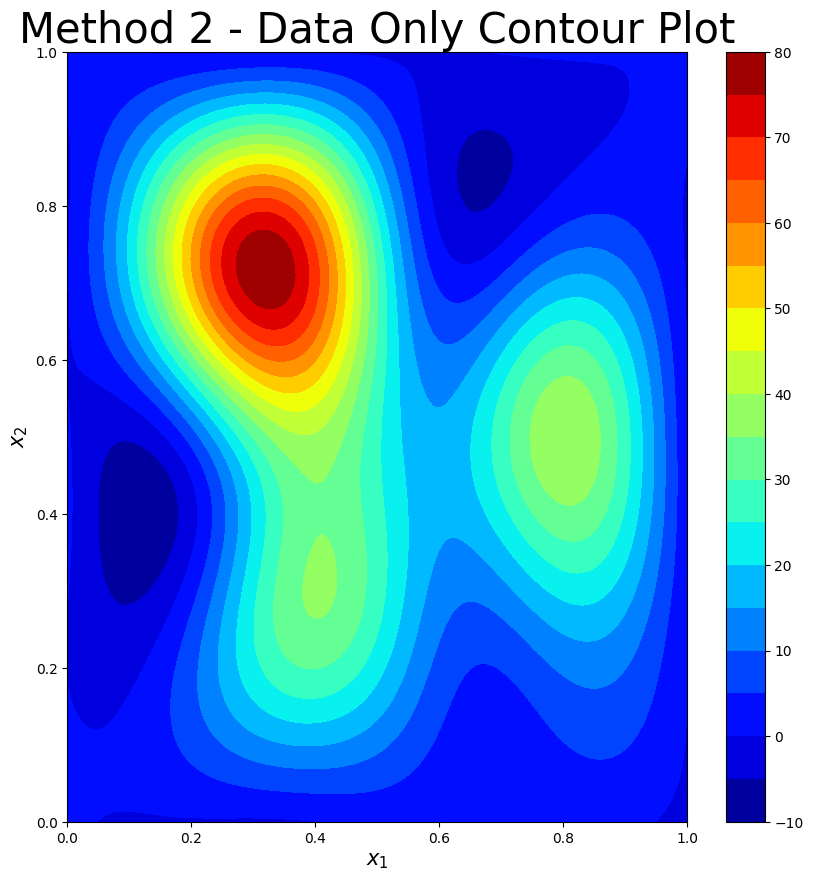

In [28]:
fig = plt.figure(figsize=(10,10))
SX1, SX2 = np.meshgrid(X1[0,:],X2[:,0])
plt.contourf(SX1,SX2,T,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Truth Contour Plot',fontsize=30)

newphi = Forward(params,X1.reshape(-1,1).reshape(-1,),X2.reshape(-1,1).reshape(-1,))
plotphi = newphi.reshape(101,101)

fig2 = plt.figure(figsize=(10,10))
plt.contourf(X1,X2,plotphi,cmap='jet',levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Method 2 - Data Only Contour Plot',fontsize=30)

### Comparing Truth vs Data Only Regression Model

The data only regression model generated by Method 2 is a poor estimate of truth.  This is due to using a fixed basis (GRB) regression technique as opposed to a neural network method, which is superior.  Another reason is due to how this method performs in the low-data regime.  Evidently, with a minimum data only approach, the generated model is a poor representation of truth.

## Method 2, Part 5: Physics-Informed Regression Model
# **NOTE**:
I had to $\bf{drastically}\space\bf{reduce}$ the size of the overall model complexity (M), number of data points used for the physics informed model (N_Model), and the number of training iterations (epochs).  When running the given code, google colab would crash with an error indicating I ran out of RAM.


In [29]:
K  = 25*25
s  = 0.25**2
mu = jax.random.uniform(key, shape=(2, K))


def Init(K, key):
    return [jax.random.uniform(key, (K,1), minval=-1.0, maxval=1.0)]

def Forward(params, x1, x2):

    phi = jnp.exp(-(((x1.reshape(-1,1)-mu[0].reshape(1,K))**2)/s))*jnp.exp(-(((x2.reshape(-1,1)-mu[1].reshape(1,K))**2)/s))

    f_hat = phi @ params[0]
    return f_hat.squeeze()

learning_rate, epochs = 1e-1, 100000
params = Init(K, key)

In [30]:
data = jnp.load('data.npz')
X1, X2, T, I = data['X1'], data['X2'], data['T'], data['I']

L = 1
k = 0.1
N_test  = 75
N_Model = 500
sigma = 2

I_train, I_test = I[N_test:], I[:N_test]

X_train = jnp.hstack((X1.reshape(-1,1)[I_train], X2.reshape(-1,1)[I_train]))
Y_train = T.ravel()[I_train] + sigma*jax.random.normal(key, shape=(len(I_train),))

X_test = jnp.hstack((X1.reshape(-1,1)[I_test], X2.reshape(-1,1)[I_test]))
Y_test = T.ravel()[I_test]

X_model = L*jax.random.uniform(key, shape=(N_Model,2))

q = lambda X: -250*jnp.exp(-20*(X[:,0]-L/6)**2-20*(X[:,1]-L/2)**2)

In [31]:
d2y_dx1 = jit(vmap(grad(grad(Forward, 1), 1), in_axes=(None, 0, 0)))
d2y_dx2 = jit(vmap(grad(grad(Forward, 2), 2), in_axes=(None, 0, 0)))

@jit
def Loss(params, X_data, Y_data, X_model):
    prediction_data = Forward(params,X_data[:,0],X_data[:,1])
    loss_data = jnp.mean((Y_data - prediction_data)**2)
    loss_model = jnp.mean((0.1*(d2y_dx1(params,X_model[:,0],X_model[:,1]) + d2y_dx2(params,X_model[:,0],X_model[:,1])) - q(X_model))**2)
    loss = loss_data + loss_model
    return loss

Gradients = grad(Loss)

In [32]:
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

@jit
def step(params, opt_state):
    gradients = Gradients(params, X_train, Y_train, X_model)
    updates, opt_state = optimizer.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [33]:
y_tr22 = []
y_te22 = []

for i in range(epochs):
    y_tr2 = Loss(params, X_train, Y_train, X_model)
    y_te2 = Loss(params, X_test, Y_test, X_model)
    params, opt_state = step(params, opt_state)

    y_tr22.append(y_tr2)
    y_te22.append(y_te2)


Text(0.5, 1.0, 'Method 2 - Physics-Informed Contour Plot')

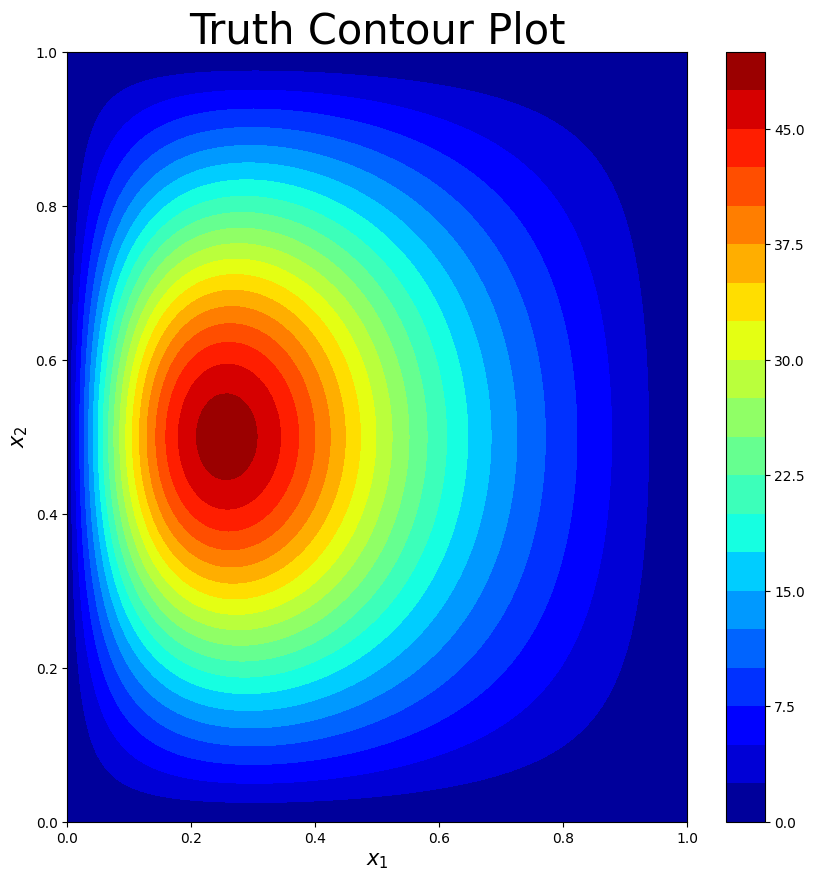

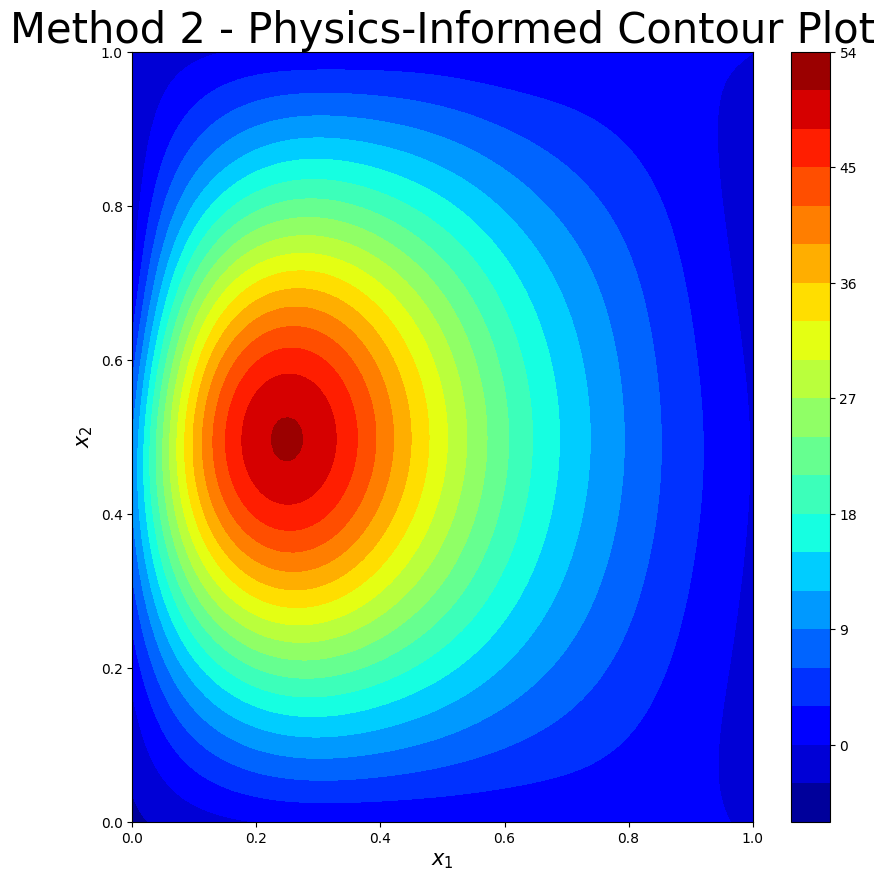

In [35]:
fig = plt.figure(figsize=(10,10))
plt.contourf(SX1,SX2,T,cmap='jet', levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Truth Contour Plot',fontsize=30)

plotphi = Forward(params,X1.reshape(-1,1).reshape(-1,),X2.reshape(-1,1).reshape(-1,))
PIreg = plotphi.reshape(101,101)

fig2 = plt.figure(figsize=(10,10))
plt.contourf(X1,X2,PIreg,cmap='jet',levels = 20)
plt.colorbar()
plt.xlabel(r'$x_{1}$',fontsize = 15)
plt.ylabel(r'$x_{2}$',fontsize = 15)
plt.title(r'Method 2 - Physics-Informed Contour Plot',fontsize=30)

### Comparing Physics-Informed Approach to Data Only Model

Since Method 2 is bound to using a basis function (Gaussian Radial Basis) to estimate the model, the data only approach produces a poor model as shown by the first contiue plot.  This is due to the limited amount of data as well as not using the neural network approach.  When adding a physics-informed regularizer to the model, the results are better.  However, as noted above, I had to drastically reduce the data and training iterations.  This highlights an additional problem when using basis techniques for regression.

## Method 2, Part 6: Generalization Error & Training Error for PINN

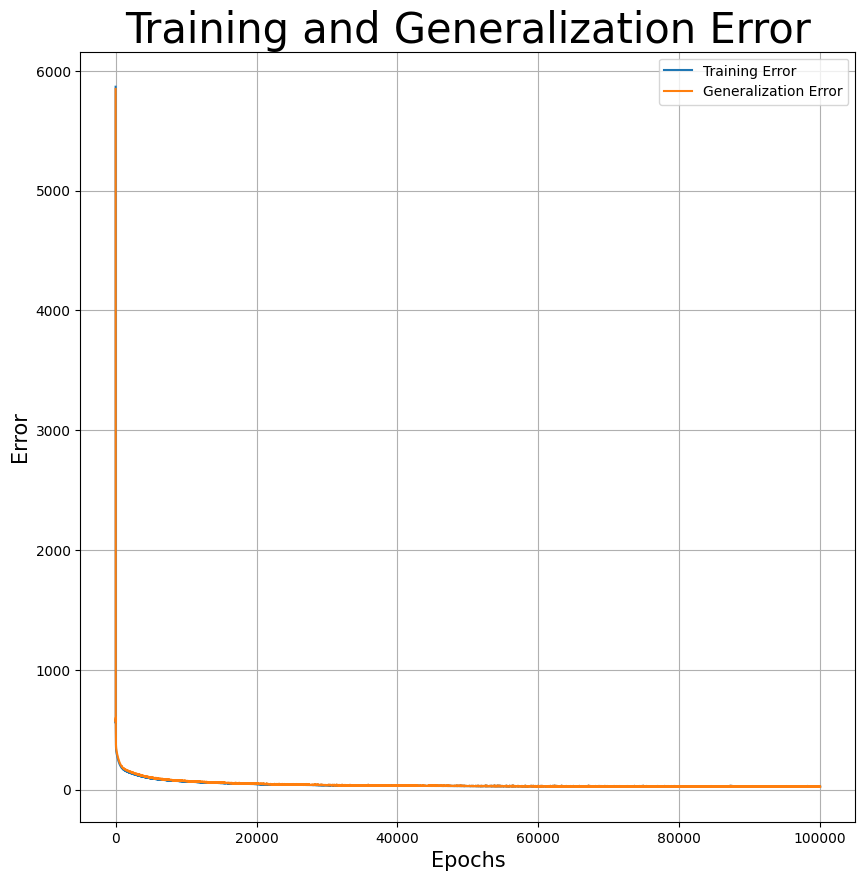

In [36]:
it_plot = jnp.linspace(1,epochs,epochs)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(it_plot, y_tr22, label = 'Training Error')
ax.plot(it_plot, y_te22, label = 'Generalization Error')
ax.set_xlabel('Epochs', fontsize = 15)
ax.set_ylabel('Error', fontsize = 15)
ax.grid('major')
plt.title('Training and Generalization Error', fontsize = 30)
plt.legend()